In [1]:
#Imports
import timm
from fastai.vision.all import *
from fastai.learner import Callback
import pandas as pd
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import torch
from torchvision.models import inception_v3


In [3]:
import torch
print(f"Using CUDA: {torch.cuda.is_available()}")


Using CUDA: True


In [2]:
# Reading in the training data
csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')
train_data = pd.read_csv(csv_path)
train_dir = os.path.join('COMP90086_2024_Project_train', 'train')
print(train_data.head())


    id  shapeset  type  total_height  instability_type  cam_angle  \
0   54         2     1             3                 1          1   
1  173         1     1             4                 1          2   
2  245         1     1             4                 1          2   
3  465         2     1             5                 0          1   
4  611         2     1             3                 1          1   

   stable_height  
0              2  
1              1  
2              1  
3              5  
4              1  


In [5]:
# Test learning rate optimization (learn.lr_find())
# Define the path to your CSV file
csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')

# Read the CSV file into a DataFrame
train_data = pd.read_csv(csv_path)

# Adding a column with the complete image path
train_data['image_path'] = train_data['id'].apply(lambda x: os.path.join('COMP90086_2024_Project_train', 'train', f"{x}.jpg"))

# Ensure that the 'stable_height' column contains categorical data for classification
train_data['stable_height'] = train_data['stable_height'].astype(str)  # Convert targets to string if they are numerical

# Convert your DataFrame to a FastAI DataBlock for classification
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image as input and categorical target
    get_x=ColReader('image_path'),       # Path to the image
    get_y=ColReader('stable_height'),    # Target column
    splitter=RandomSplitter(valid_pct=0.2)  # Splitting the data into training and validation sets
)

# Create a DataLoader
dls = dblock.dataloaders(train_data, bs=8, num_workers=0)  # Adjust batch size as needed

# Create a FastAI learner using ResNet50 for classification
learn = vision_learner(dls, resnet50, metrics=accuracy, loss_func=CrossEntropyLossFlat())

# Train the model using fine-tuning
learn.fine_tune(5)  # Adjust the number of epochs as needed

# Save the trained model
learn.save('resnet50_trained_model')


epoch,train_loss,valid_loss,accuracy,time
0,2.137764,1.830133,0.238281,01:42


epoch,train_loss,valid_loss,accuracy,time
0,1.747649,1.645882,0.278646,01:50
1,1.544407,1.542037,0.348307,01:30
2,1.437785,1.328362,0.429688,01:57
3,1.103440,1.330701,0.467448,02:27
4,0.794801,1.357205,0.462891,01:56


Path('models/resnet50_trained_model.pth')

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


SuggestedLRs(valley=0.0003311311302240938)

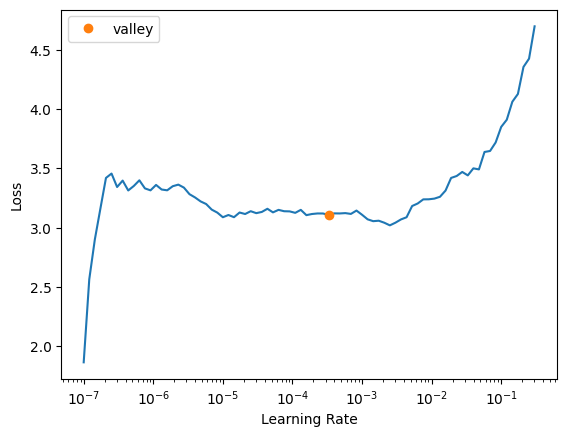

In [11]:
learn = vision_learner(dls, resnet50, metrics=accuracy, loss_func=CrossEntropyLossFlat())
learn.lr_find()

In [6]:
# Test learning rate optimization (learn.lr_find())
# Define the DataBlock for a classification task
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image as input and categorical target
    get_x=ColReader('image_path'),       # Path to the image
    get_y=ColReader('stable_height'),    # Column for target labels (ensure they are categorical values)
    splitter=RandomSplitter(valid_pct=0.2), # Splitting the data into training and validation sets
    item_tfms=Resize(299)  # Resize images to 299x299, the required input size for InceptionV3
)

# Create a DataLoader
dls = dblock.dataloaders(train_data, bs=8)  # Adjust the batch size based on your GPU memory

# Modify the InceptionV3 model for classification
class InceptionV3Custom(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = inception_v3(weights="DEFAULT")
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Adjust final layer for classification

    def forward(self, x):
        if self.training:
            logits, aux_logits = self.model(x)
            return logits
        else:
            return self.model(x)

# Determine the number of classes from the training data
num_classes = len(train_data['stable_height'].unique())

# Initialize the modified InceptionV3 model for classification
inception_model = InceptionV3Custom(num_classes)

# Create a FastAI learner using the modified Inception model
learn = Learner(dls, inception_model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Train the model using fine-tuning
learn.fine_tune(5)  # Adjust the number of epochs as needed

learn.save('inception_v3_trained_model')


epoch,train_loss,valid_loss,accuracy,time
0,1.739501,6.460899,0.260417,02:59


epoch,train_loss,valid_loss,accuracy,time
0,1.680515,2.897394,0.238281,02:44
1,1.699164,1.720996,0.253255,02:45
2,1.600739,1.654440,0.256510,02:22
3,1.602728,1.565576,0.264323,03:07
4,1.594912,1.552683,0.265625,03:10


Path('models/inception_v3_trained_model.pth')

SuggestedLRs(valley=0.0014454397605732083)

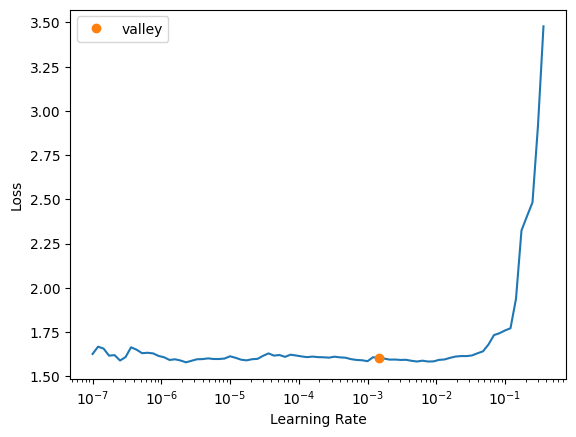

In [12]:
learn = Learner(dls, inception_model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.lr_find()

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


epoch,train_loss,valid_loss,accuracy,time
0,2.097288,1.816184,0.264323,04:06


epoch,train_loss,valid_loss,accuracy,time
0,1.702007,1.551758,0.332682,05:46
1,1.520685,1.340063,0.430990,05:33
2,1.341435,1.208706,0.495443,04:47
3,1.171100,1.165234,0.535807,05:34
4,1.102494,1.116899,0.551432,05:35


Path('models/vit_trained_model.pth')

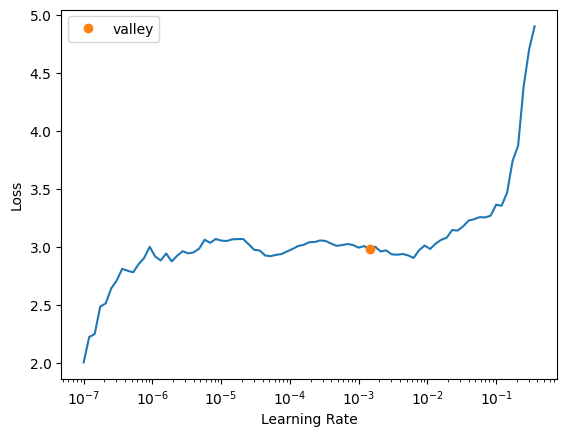

In [3]:
# Vision Transformer Model

# Define the path to your CSV file and training images
csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')
train_dir = os.path.join('COMP90086_2024_Project_train', 'train')

# Read the CSV file into a DataFrame
train_data = pd.read_csv(csv_path)

# Add a column with the complete image path
train_data['image_path'] = train_data['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))

# Ensure that the 'stable_height' column is treated as a string for classification
train_data['stable_height'] = train_data['stable_height'].astype(str)

# Create a DataBlock for the Vision Transformer
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the input and output types
    get_x=ColReader('image_path'),       # Read the image paths
    get_y=ColReader('stable_height'),    # Read the target labels
    splitter=RandomSplitter(valid_pct=0.2),  # Split into training and validation sets
    item_tfms=Resize(224),               # Resize images to 224x224 (required by ViT)
    batch_tfms=aug_transforms()          # Apply data augmentation
)


# Create the DataLoaders
dls = dblock.dataloaders(train_data, bs=8, num_workers=0)  # Adjust batch size and num_workers as needed

# Create a Vision Transformer model using timm
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=dls.c)

# Create a FastAI learner
learn = vision_learner(dls, 'vit_base_patch16_224', metrics=accuracy, pretrained=True)

# Find the optimal learning rate
learn.lr_find()

# Fine-tune the model
learn.fine_tune(5)  # Adjust the number of epochs as needed
learn.save('vit_trained_model')


In [ ]:
class VisionTransformerTrainer:
    def __init__(self, csv_path, train_dir, model_name='vit_base_patch16_224', image_size=224, batch_size=8, valid_pct=0.2):
        """
        Initializes the Vision Transformer Trainer.
        
        Args:
            csv_path (str): Path to the CSV file containing data.
            train_dir (str): Directory where training images are located.
            model_name (str): Name of the model from timm (default is 'vit_base_patch16_224').
            image_size (int): Size to resize images (default is 224x224).
            batch_size (int): Batch size for training (default is 8).
            valid_pct (float): Percentage of data to use for validation (default is 0.2).
        """
        self.csv_path = csv_path
        self.train_dir = train_dir
        self.model_name = model_name
        self.image_size = image_size
        self.batch_size = batch_size
        self.valid_pct = valid_pct
        self.learn = None  # Placeholder for the learner object

        # Load data
        self._prepare_data()

        # Initialize DataLoaders
        self._create_dataloaders()

    def _prepare_data(self):
        # Read the CSV file
        self.train_data = pd.read_csv(self.csv_path)

        # Add a column with the complete image path
        self.train_data['image_path'] = self.train_data['id'].apply(lambda x: os.path.join(self.train_dir, f"{x}.jpg"))

        # Ensure the 'stable_height' column is treated as a string for classification
        self.train_data['stable_height'] = self.train_data['stable_height'].astype(str)

    def _create_dataloaders(self):
        # Create a DataBlock for the Vision Transformer
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),  # Define input and output types
            get_x=ColReader('image_path'),       # Read the image paths
            get_y=ColReader('stable_height'),    # Read the target labels
            splitter=RandomSplitter(valid_pct=self.valid_pct),  # Split into training and validation sets
            item_tfms=Resize(self.image_size),   # Resize images to the required size
            batch_tfms=aug_transforms()          # Apply data augmentation
        )

        # Create the DataLoaders
        self.dls = dblock.dataloaders(self.train_data, bs=self.batch_size, num_workers=0)

    def initialize_model(self, pretrained=True):
        # Create a Vision Transformer model using timm
        self.model = timm.create_model(self.model_name, pretrained=pretrained, num_classes=self.dls.c)

        # Create a FastAI learner
        self.learn = vision_learner(self.dls, self.model_name, metrics=accuracy, pretrained=pretrained)

    def find_learning_rate(self):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        self.learn.lr_find()

    def fine_tune(self, epochs=5):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        self.learn.fine_tune(epochs)
        print("Training complete.")

    def save_model(self, model_name='vit_trained_model'):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        self.learn.save(model_name)
        print(f"Model saved as {model_name}")

    def load_model(self, model_name='vit_trained_model'):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        self.learn.load(model_name)
        print(f"Model loaded from {model_name}")

    def predict(self, image_path):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        
        # Predict on a single image
        img = PILImage.create(image_path)
        pred, pred_idx, probs = self.learn.predict(img)
        return {'id': os.path.basename(image_path).split('.')[0], 'predicted_stable_height': pred, 'probability': probs[pred_idx].item()}


In [21]:
# Initialize the Vision Transformer model using timm
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=dls.c)

# Create the learner
learn = vision_learner(dls, 'vit_base_patch16_224', metrics=accuracy, pretrained=True)

# Load the saved model weights (assuming the model was saved as 'vit_trained_model.pth')
learn.load('vit_trained_model')


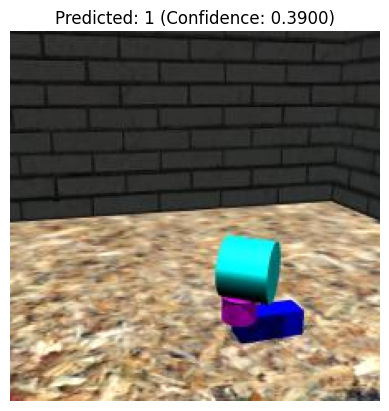


All class probabilities:
Class: 1, Probability: 0.3900
Class: 2, Probability: 0.2037
Class: 3, Probability: 0.3801
Class: 4, Probability: 0.0206
Class: 5, Probability: 0.0030
Class: 6, Probability: 0.0028


In [26]:
import matplotlib.pyplot as plt
from fastai.vision.all import PILImage

# Load the image for prediction
img_path = 'COMP90086_2024_Project_train/train/100202.jpg'
img = PILImage.create(img_path)

# Make predictions using the trained model
pred, pred_idx, probs = learn.predict(img)

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {pred} (Confidence: {probs[pred_idx].item():.4f})")
plt.axis('off')
plt.show()

# Print all class labels with their corresponding probabilities
print("\nAll class probabilities:")
for label, prob in zip(learn.dls.vocab, probs):
    print(f"Class: {label}, Probability: {prob.item():.4f}")


In [ ]:
# Define paths
csv_path = 'COMP90086_2024_Project_train/train.csv'
train_dir = 'COMP90086_2024_Project_train/train'

# Initialize the Vision Transformer Trainer
trainer = VisionTransformerTrainer(csv_path, train_dir, model_name='vit_base_patch16_224', image_size=224, batch_size=8)

# Initialize the model
trainer.initialize_model(pretrained=True)

# Find the optimal learning rate
trainer.find_learning_rate()

# Fine-tune the model
trainer.fine_tune(epochs=5)

# Save the trained model
trainer.save_model('vit_trained_model')

# Predict using the trained model
prediction = trainer.predict('/path/to/test_image.jpg')
print(prediction)


In [ ]:
# Vision Transformer and adding on features as input

# Define the path to your CSV file and training images
csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')
train_dir = os.path.join('COMP90086_2024_Project_train', 'train')

# Read the CSV file into a DataFrame
train_data = pd.read_csv(csv_path)

# Add a column with the complete image path
train_data['image_path'] = train_data['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))

feature_columns = ['shapeset', 'type', 'total_height', 'instability_type', 'cam_angle']
train_data[feature_columns] = train_data[feature_columns].astype(float)  # Ensure all feature columns are float

# Ensure that the 'stable_height' column is treated as a string for classification
train_data['stable_height'] = train_data['stable_height'].astype(str)

# Define a DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Using ImageBlock and categorical target
    get_x=ColReader('image_path'),       # Get the image path
    get_y=ColReader('stable_height'),    # Get the target label
    splitter=RandomSplitter(valid_pct=0.2),  # 80/20 train/validation split
    item_tfms=Resize(224),               # Resize images to 224x224 for ViT
    batch_tfms=aug_transforms()          # Apply standard augmentations
)

# Create the DataLoaders
dls = dblock.dataloaders(train_data, bs=8, num_workers=0)  # Adjust batch size as needed

# Load a pre-trained Vision Transformer model using timm
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=dls.c)

# Define a custom model that combines the ViT with additional features
class VisionTransformerWithFeatures(nn.Module):
    def __init__(self, vit_model, num_features, num_classes):
        super(VisionTransformerWithFeatures, self).__init__()
        self.vit_model = vit_model
        
        # Define a simple feedforward network for the tabular features
        self.feature_extractor = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Define the final classifier combining both ViT features and tabular features
        self.classifier = nn.Linear(vit_model.head.in_features + 64, num_classes)
        
    def forward(self, x, features=None):
        # Extract features from the ViT model
        vit_features = self.vit_model.forward_features(x)  # Extract features without the classifier head
        
        if features is not None:
            # Extract features from the tabular data
            feature_embedding = self.feature_extractor(features)
            # Concatenate image and tabular features
            combined_features = torch.cat((vit_features, feature_embedding), dim=1)
        else:
            # Use only image features during inference
            combined_features = vit_features
        
        # Pass the combined features through the final classifier
        return self.classifier(combined_features)
    
# Initialize the custom model
num_features = len(feature_columns)
num_classes = len(train_data['stable_height'].unique())
custom_model = VisionTransformerWithFeatures(vit_model, num_features=num_features, num_classes=num_classes)

# Create a FastAI learner
learn = Learner(dls, custom_model, metrics=accuracy)

learn.find_lr()

# Train the model
learn.fine_tune(5)  # Adjust the number of epochs as needed


In [7]:
# Define the path to your test CSV file
test_csv_path = os.path.join('COMP90086_2024_Project_test', 'test.csv')

# Read the CSV file into a DataFrame
test_data = pd.read_csv(test_csv_path)

# Adding a column with the complete image path
test_data['image_path'] = test_data['id'].apply(lambda x: os.path.join('COMP90086_2024_Project_test', 'test', f"{x}.jpg"))

# Create a DataLoader for the test set
test_dls = dls.test_dl(test_data)  # Use test_dl to create a DataLoader for testing



In [8]:
learn = learn.load('inception_v3_trained_model')